In [13]:
import glob
import os
import random
import pandas as pd
import numpy as np 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.layers import Dropout
from keras.layers import Dense
from keras import models
from sklearn.ensemble import IsolationForest
from keras import optimizers
import itertools
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
os.chdir("/scratch/rk9cx/conn_log_labelled_runtime/labelled_2019-01-11//")
from datetime import datetime, timedelta
import numpy as np
import math

In [ ]:
#preprocessing data
df = pd.read_csv(filename, skiprows=skip)
df = pd.concat([df, df['history'].str.join('|').str.get_dummies()], axis = 1)
df = df.drop(["history","honeypot","blacklist","whitelist"], axis=1)
df = pd.concat([df, pd.get_dummies(df.conn_state.apply(pd.Series), prefix="", prefix_sep="")], axis = 1)
df = df.drop(["conn_state"], axis=1)
df = df.replace('-', 0)

In [6]:
train = pd.read_csv("/scratch/rk9cx/conn_log_labelled_runtime/labelled_2019-01-10/sample.csv", 
                    index_col= False)

In [3]:
#random sampling
filename = "merged.csv"
n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
s = 1000000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
df = pd.read_csv(filename, skiprows=skip)
test = df

In [7]:
from fastai.imports import *
from fastai.structured import *

In [66]:
def preprocess(df):
    df = pd.concat([df, df['history'].str.join('|').str.get_dummies()], axis = 1)
    df = df.drop(["history","honeypot","blacklist","whitelist"], axis=1)
    df = pd.concat([df, pd.get_dummies(df.conn_state.apply(pd.Series), prefix="", prefix_sep="")], axis = 1)
    df = df.drop(["conn_state"], axis=1)
    df = df.replace('-', 0)
    rf_sample = df.drop(["src_ip_ext","src_ip","dest_ip"], axis=1)
    rf_sample["duration"] = rf_sample["duration"].astype(float)
    rf_sample["duration"] = np.log((rf_sample["duration"].astype('int'))+0.001)
    rf_sample["src_bytes"] = rf_sample["src_bytes"].astype(float)
    rf_sample["src_bytes"] = np.log((rf_sample["src_bytes"].astype('int'))+0.001)
    rf_sample["dest_bytes"] = rf_sample["dest_bytes"].astype(float)
    rf_sample["dest_bytes"] = np.log((rf_sample["dest_bytes"].astype('int'))+0.001)
    rf_sample["src_pkts"] = np.log((rf_sample["src_pkts"].astype('int'))+0.001)
    rf_sample["dest_pkts"] = np.log((rf_sample["dest_pkts"].astype('int'))+0.001)
    rf_sample['ts'] = pd.to_datetime(rf_sample['ts'],unit='s')
    rf_sample["src_port"] = rf_sample["src_port"].astype('category')
    rf_sample["dest_port"] = rf_sample["dest_port"].astype('category')
    rf_sample["src_port"] = rf_sample["src_port"].cat.codes
    rf_sample["dest_port"] = rf_sample["dest_port"].cat.codes
    xhr, yhr = [], []
    for i in df.ts:
        temp = (datetime.fromtimestamp(i) - timedelta(hours=-5)).strftime('%Y-%m-%d %H:%M:%S')[11:13]
        xhr.append(np.sin(2*math.pi*int(temp)/24))
        yhr.append(np.cos(2*math.pi*int(temp)/24))

    rf_sample['xhr'] = xhr
    rf_sample['yhr'] = yhr
    add_datepart(rf_sample, 'ts')
    rf_sample = class_balancer(rf_sample)
    X = rf_sample.loc[:, rf_sample.columns != 'label']
    Y = rf_sample.loc[:, rf_sample.columns == 'label']
    return X,Y

In [8]:
#function for plotting confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [76]:
df.label.value_counts()

1    782657
0    217343
Name: label, dtype: int64

In [64]:
        mal = df.loc[df['label'] == 1].head(df.label.value_counts()[0])
        ben = df.loc[df['label'] == 0]
        mdf = pd.concat([mal,ben], axis = 0)
        mdf.label.value_counts()

1    217343
0    217343
Name: label, dtype: int64

In [65]:
def class_balancer(df):
    if df.label.value_counts()[0] > df.label.value_counts()[1]:
        mal = df.loc[df['label'] == 1]
        ben = df.loc[df['label'] == 0].head(df.label.value_counts()[1])
        mdf = pd.concat([mal,ben], axis = 0)
        return mdf
    if df.label.value_counts()[1] > df.label.value_counts()[0]:
        mal = df.loc[df['label'] == 1].head(df.label.value_counts()[0])
        ben = df.loc[df['label'] == 0]
        mdf = pd.concat([mal,ben], axis = 0)
        return mdf

In [67]:
X_train,y_train = preprocess(train)

In [68]:
X_test,y_test = preprocess(test)

In [85]:
X_test.columns

Index(['src_port', 'dest_port', 'duration', 'src_bytes', 'dest_bytes',
       'src_pkts', 'dest_pkts', 'local', 'A', 'D', 'F', 'H', 'R', 'S', 'T',
       '^', 'a', 'd', 'f', 'h', 'i', 'q', 'r', 's', 't', 'OTH', 'REJ', 'RSTO',
       'RSTOS0', 'RSTR', 'RSTRH', 'S0', 'S1', 'S2', 'S3', 'SF', 'SH', 'SHR',
       'xhr', 'yhr'],
      dtype='object')

In [81]:
time_col = ['tsYear', 'tsMonth', 'tsWeek', 'tsDay', 'tsDayofweek',
       'tsDayofyear', 'tsIs_month_end', 'tsIs_month_start', 'tsIs_quarter_end',
       'tsIs_quarter_start', 'tsIs_year_end', 'tsIs_year_start', 'tsElapsed']

In [84]:
X_test.drop(time_col, axis = 1, inplace=True)
X_train.drop(time_col, axis = 1, inplace=True)

In [91]:
m = RandomForestClassifier(n_estimators=500, max_features=0.5, n_jobs=-1)
m.fit(X_train, y_train) 

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Confusion matrix, without normalization
[[194589  22754]
 [ 23136 194207]]


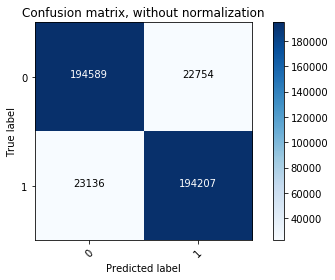

In [92]:
pred_y = m.predict(X_test)
cm= confusion_matrix(y_test, pred_y)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix, without normalization')

In [93]:
tn, fp, fn, tp = cm.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fpr = fp/(fp+ tn)
accuracy = (tp + tn)/(tn + tp + fn + fp)
print(precision, recall, fpr*100, accuracy*100)

0.8951240084623504 0.893550746975978 10.469166248740471 89.44295422442868


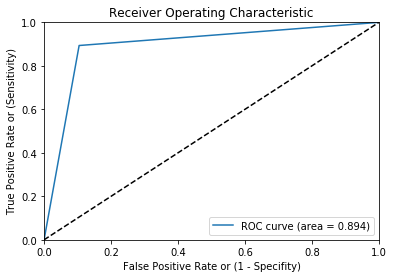

In [94]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, pred_y)
roc_auc = auc(fpr,tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

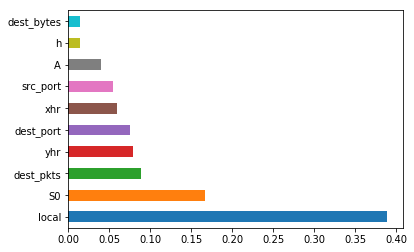

In [95]:
feat_importances = pd.Series(m.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')